# Rideshare Demand Prediction with Random Forest Regression

**Background**

Since November 2018, rideshare providers (Lyft, Uber, etc) operating in Chicago are required by ordinance to submit periodic data reports with basic rideshare information to the City.  The main [Trips dataset](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p) includes information about individual rides, including starting and ending times and locations, fares and tips, and whether the rides were pooled.  The Trips data are anonymized, so trip starting and ending locations are generalized to the nearest census tract, and drivers cannot be linked to particular rides they provided.  The currently available dataset goes through June 2019, however the portion used for this exercise goes from November 2018 through March 2019.

To prepare for the analyses and visualizations in this notebook, the Trips data was cleaned, aggregated, and enriched with climate and census data.  A preliminary exploration of this dataset is available [here](https://github.com/LisaATaylor/Rideshare/blob/master/Chicago%20Rideshare%20Data%20Story.ipynb).

The primary question explored by this notebook is how well can we predict rideshare demand for a given location as a function of day of week and time of day?  We are also interested in knowing whether the additional information that has been added to enrich the base dataset (ie climate, census, and distance data) may improve the predictive power of the models.

1.  [Setup and data loading](#setup)
2.  [Prediction of rideshare demand by OLS](#ols)
3.  [Prediction of rideshare demand by non-parametric model](#np)
4.  [Enhancement of dataset - adding 'Bearing' field](#zero)
5.  [Parameter tuning](#param)
6.  [Final results](#final)


<a id='setup'></a>

---

## 1. Setup and Data Loading

In [3]:
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as ctx #for basemaps
import scipy.stats as stats

In [4]:
plt.rcParams['figure.figsize'] = [15, 5]
sns.set()
import warnings; warnings.simplefilter('ignore')

In [5]:
#load pickled/munged data 
datadir=r'/Users/rtaylor/Desktop/Springboard/DataSets/Rideshare'

#data from 5% sample from Trips dataset, aggregated by pickup census tract and hour
agg_hourly_all=pd.read_pickle(os.path.join(datadir,'agg_hourly_all_gdf'))


In [6]:
agg_hourly_all.iloc[0]

Fare                                                                 5
Tip                                                                  0
AdditionalCharges                                                  2.5
TripTotal                                                          7.5
TripMiles                                                          1.9
TripSeconds                                                      683.5
Year                                                              2018
Month                                                               11
DOW                                                                  3
Hour                                                                16
NumRides                                                             2
HTemp                                                               48
HWind                                                               21
HPrecip                                                              0
Precip

#### About the data:
The hourly aggregated rideshare dataset was generated by grouping the raw rides data by census tract and time rounded to the nearest hour.  The fields derived from the Trips dataset (Fare, Tip, Trip Miles, etc.) are average values for all rides in each time/space grouping.  The count of rides per grouping is used to derive the NumRides field.  This data has been enriched with weather data (HTemp = hourly temperature, HPrecip = hourly precipitation accumulation, HWind= hourly average wind speed, Precip = flag whether precipitation occurred), plus limited census-derived and geographic data for each census tract (Med Income, Population Density, Distance to Downtown).

Each record in the aggregated dataset represents a summary of rideshare activity at a location for a given date and time (to nearest hour).  Since the dataset used for aggregation only includes 5% of the total rides, the computed ride counts can be considered estimates of 5% of total utiliztion.  For this analysis, each record has been decoupled from the actual month/date/year and acts an individual sample representative of a day of week and hour of day. For instance, for a given tract there will be multiple samples of ride count or average fare for a given Wednesday at 4pm.  There are no records for tracts at times when they had no rides (i.e. NumRides is always >=1).

In [7]:
agg_hourly_all['MedIncome']=agg_hourly_all.MedIncome.astype('int') #was object

In [8]:
#Some of the variables in this dataset are strongly corellated
agg_hourly_all[['TripTotal','Fare','TripMiles','TripSeconds','DistToDowntown','PopDensity','MedIncome']].corr()

,TripTotal,Fare,TripMiles,TripSeconds,DistToDowntown,PopDensity,MedIncome
TripTotal,1.000000,0.971472,0.820143,0.667418,0.189242,-0.058795,-0.335548
Fare,0.971472,1.000000,0.833237,0.710880,0.206805,-0.061765,-0.290182
TripMiles,0.820143,0.833237,1.000000,0.786245,0.283238,-0.104236,-0.303378
TripSeconds,0.667418,0.710880,0.786245,1.000000,0.234138,-0.081948,-0.183287
DistToDowntown,0.189242,0.206805,0.283238,0.234138,1.000000,-0.200470,-0.270998
PopDensity,-0.058795,-0.061765,-0.104236,-0.081948,-0.200470,1.000000,0.147297
MedIncome,-0.335548,-0.290182,-0.303378,-0.183287,-0.270998,0.147297,1.000000


<a id='demand_predict'></a>

<a id='ols'></a>

## 2. Prediction of  rideshare demand by simple OLS regression approach

First I attempted a basic linear regression approach to see if a simple linear model may be effective at predicting ride counts at specified locations and times. The exploratory data analysis showed strong cyclical effects in rideshare usage at the hourly and daily levels, and a strong relationship between demand and distance to downtown at certain times of day. Given the repeatability of the usage data, I attempt to predict usage by distance from downtown, a general date and time (i.e. weekend or weekday, time of day), and other variables which may influence demand (weather, etc). 

Some new engineered features were added to the dataset to see if they aid in prediction:
* **IsAirportPU:**  The preliminary data analysis indicated that the airports have different patterns than other parts of the city.  This flag identifies rides that originate at an airport.  Since we are interested in pickup demand, not dropoff demand, we only derive this for pickups.
* **DayPeriod:**  If hour of day is used as a model parameter, there is no way to inform the model that hour is cyclical (i.e. 0:00 is close to both 23:00 and 1:00), other than performing a sin/cos-type transform.  As a simpler approach, I derived time of day groupings (i.e. morning, afternoon, etc) that can be used as a categorical indicator of the time of day.
* **IsWeekday:**  The time series usage data showed very different behavior between weekday and weekend rides.  This field was added to see if a categorical flag for weekend/weekday may produce better results than day of week.

Several of the features in the original Trips dataset are strongly correlated (i.e. fare, trip duration, trip distance).  Due to these strong relationships I only incorporated a single one of these features in each attempted regression model to avoid multicolinearity. 

A potential issue with this simple approach to predicting rideshare usage that it doesn't account for spatial autocorrelation (i.e. similar behavior between neighboring census tracts) or temporal autocorrelation (i.e. similar behavior in adjacent time periods). For this work I have assumed that individual rideshare consumer decisions are independent of those made in adjacent census tracts and at earlier or later times.  Additional work to improve this regression approach would involve validating these assumptions.  


In [9]:
#Derived fields

agg_hourly_all=agg_hourly_all.reset_index() 

#Add in airport flag
agg_hourly_all['IsAirportPU']=0
agg_hourly_all.loc[agg_hourly_all.PUCensusTract.isin(['17031980000','17031980100']),'IsAirportPU']=1

#add flag to indicate period of day
agg_hourly_all['DayPeriod'] = pd.cut(agg_hourly_all['Hour'], bins=[-1,6, 10, 14, 17, 20, 24], labels=['night', 'morning', 'midday','afternoon','evening','lateevening'])

#Add flag for weekday/weekend
agg_hourly_all['IsWeekday'] = 0
agg_hourly_all.loc[agg_hourly_all.DOW<5,'IsWeekday']=1


In [10]:
agg_hourly_all[['PUCensusTract', 'TripStart', 'Fare', 'Tip', 'AdditionalCharges',
       'TripTotal', 'TripMiles', 'TripSeconds', 'Year', 'Month', 'DOW', 'Hour',
       'NumRides', 'HTemp', 'HWind', 'HPrecip', 'Precip','commarea','area_sq_km', 'MedIncome', 'Population',
       'PopDensity', 'DistToDowntown', 'IsAirportPU', 'DayPeriod',
       'IsWeekday']].iloc[0]


PUCensusTract                17031010100
TripStart            2018-11-01 16:00:00
Fare                                   5
Tip                                    0
AdditionalCharges                    2.5
TripTotal                            7.5
TripMiles                            1.9
TripSeconds                        683.5
Year                                2018
Month                                 11
DOW                                    3
Hour                                  16
NumRides                               2
HTemp                                 48
HWind                                 21
HPrecip                                0
Precip                               Dry
commarea                               1
area_sq_km                      0.380787
MedIncome                          33750
Population                          4444
PopDensity                       11670.6
DistToDowntown                   15.5667
IsAirportPU                            0
DayPeriod       

In [11]:
# Try OLS regression with statsmodels

# At this point we just want to see whether an OLS modelling approach is appropriate and can give us 
# insight into the data.
# Since we are not yet concerned with overfitting the data, the input data has not been scaled and 
# regularization has not been applied. 

import statsmodels.formula.api as smf

#I tried a variety of linear models, including with interactions bewteen parameters.  Did not achieve a model with R-squared above 0.15
#results=smf.ols('NumRides ~ DistToDowntown+TripMiles+C(DOW)+C(IsWeekday)+C(IsAirportPU)',data=agg_hourly_all).fit()
#results=smf.ols('NumRides ~ DistToDowntown+TripTotal+HTemp+C(Precip)+C(IsAirportPU)+Hour+C(DOW)',data=agg_hourly_all).fit()
results=smf.ols('NumRides ~ DistToDowntown+TripTotal+C(Precip)+C(IsAirportPU)+C(DayPeriod)+C(IsWeekday)',data=agg_hourly_all).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               NumRides   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     9429.
Date:                Mon, 28 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:51:35   Log-Likelihood:            -1.5281e+06
No. Observations:              537380   AIC:                         3.056e+06
Df Residuals:                  537369   BIC:                         3.056e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.5931      0.022    210.937      0.000       4.550       4.636
C(Precip)[T.Wet]                0.1839      0.031      6.003      0.000       0.124       0.244
C(IsAirportPU)[T.1]             9.2190      0.060    153.052      0.000       9.101       9.337
C(DayPeriod)[T.morning]         0.3546      0.020     17.369      0.000       0.315       0.395
C(DayPeriod)[T.midday]          0.4401      0.021     21.235      0.000       0.399       0.481
C(DayPeriod)[T.afternoon]       0.7442      0.022     34.596      0.000       0.702       0.786
C(DayPeriod)[T.evening]         1.6513      0.021     79.566      0.000       1.611       1.692
C(DayPeriod)[T.lateevening]     0.9898      0.022     44.611      0.000       0.946       1.033
C(IsWeekday)[T.1]              -0.2841      0.012    -22.974      0.000      -0.308      -0.260
DistToDowntown                 -0.3834      0.001   -280.178      0.000      -0.386      -0.381
TripTotal                       0.0166      0.001     18.116      0.000       0.015       0.018
==============================================================================
Omnibus:                   705369.365   Durbin-Watson:                   0.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        241496761.855
Skew:                           7.246   Prob(JB):                         0.00
Kurtosis:                     105.837   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Overall regression results:

In general, we see significant relationships between the predictors and pickup demand, however the overall predictive power of the regression model is low, and the quality of model predictions are poor. 

<a id='np'></a>

## 3.  A different approach:  non-parametric models

Given the poor performance of the linear regression model, I switched directions and attempted to implement a non-parametric modeling approach to predict rideshare usage. Unlike regression, non-parametric models make no assumption about the functional form of the relationship between the parameters and the dependent variable, and have the potential to perform better in this application.   

Non-parametric models that may be applied to this problem include k-Nearest Neighbors regression, RBF-kernel SVM regression, and tree-based regression approaches (i.e. decision trees, bagging, boosting, random forest).  Given the large dataset available to train the model, the tree-based approach was selected.  An advantage of tree-based models is that they require very little data preparation.  I start with an out-of-box Random Forest regressor, and train it on a subset of the parameters.  The results, scored on the test data, are compared with the results from out-of-box gradient boosting and bagging regressors.

In [12]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

agg_hourly_all['Precip']=agg_hourly_all['Precip'].map({'Dry':0,'Wet':1}) #convert categorical to boolean

rfrmod=RandomForestRegressor() 
X=agg_hourly_all[['DistToDowntown','Precip','IsAirportPU','Hour','IsWeekday','TripMiles']]
y=agg_hourly_all['NumRides']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
rfrmod.fit(X_train,y_train)
y_pred=rfrmod.predict(X_test)

In [13]:
#score model 
rsq=rfrmod.score(X_test,y_test) #rsquared
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print('R2:  {}   RMSE:  {} '.format(rsq,rmse))

R2:  0.7381900990716399   RMSE:  2.2872790912305496 


#### Result:  
This simple, out-of-box model achieved an R-squared of 0.74 on the test data.  The results demonstrate that rideshare pickup rates for locations within Chicago can be fairly accurately predicted using a random forest model given a few pieces of information (distance to downtown, time of day, whether its the weekday or weekend, whether its raining, average trip distance at that location/time, and whether the pickup is from the airport).  

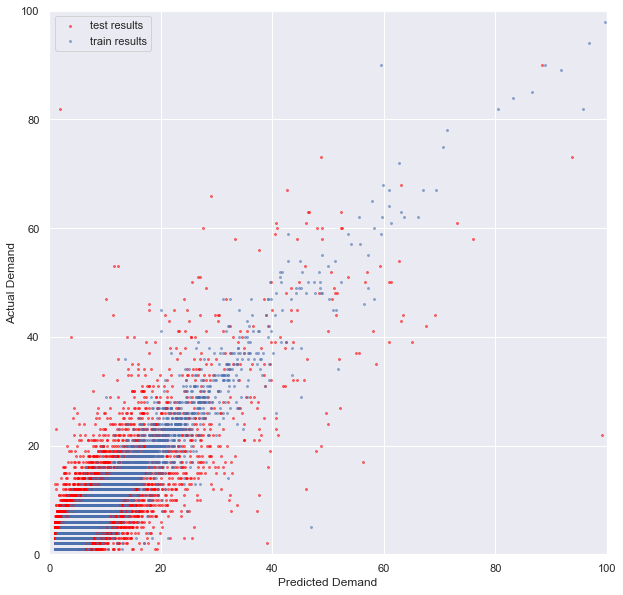

In [14]:
#Look at data graphically, plot predicted usage vs actual for first 50,000 records
fig,ax=plt.subplots(figsize=[10,10])
ax.scatter(y_pred[:50000],y_test[:50000],color='red',label='test results',s=4,alpha=0.5)
y_train_pred=rfrmod.predict(X_train)
ax.scatter(y_train_pred[:50000],y_train[:50000],label='train results',s=4,alpha=0.5)
ax.set_xlabel('Predicted Demand')
ax.set_ylabel('Actual Demand')
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.legend();


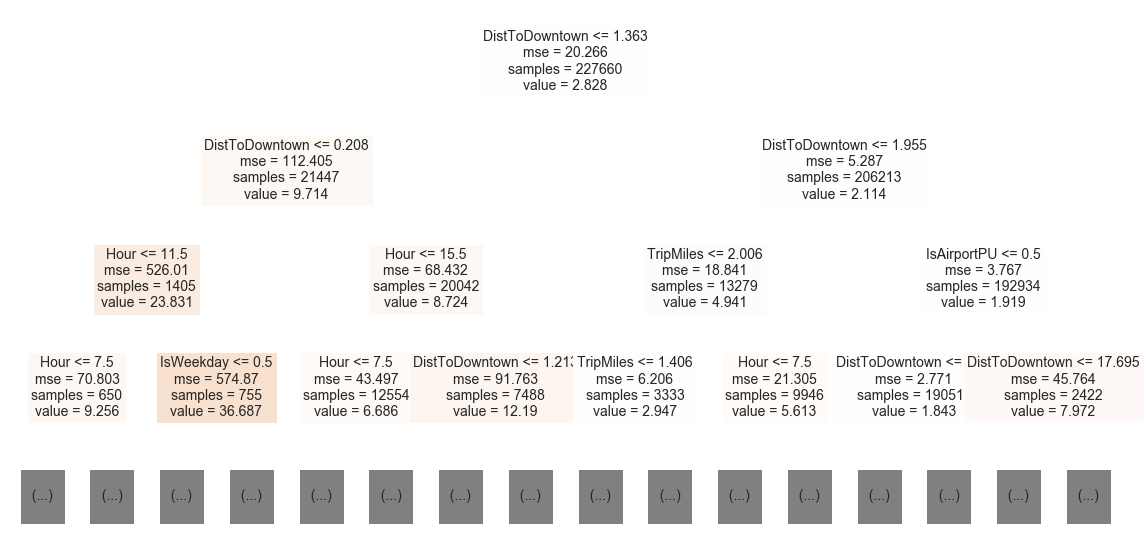

In [15]:
from sklearn.tree import plot_tree
mod=rfrmod.estimators_[8]
fig,ax=plt.subplots(figsize=(20,10))
plot_tree(mod, max_depth=3,feature_names=X_train.columns, filled=True,fontsize=14);

#to do:  figure out how to format this plot better

**Result:** 

After inspecting the top few levels of multiple models, we see splits on distance, hour and airport occuring at the top levels.

In [16]:
#Try Gradient Boosting
gbrmod=GradientBoostingRegressor() 

gbrmod.fit(X_train,y_train)
y_pred_gb=gbrmod.predict(X_test)

In [17]:
rsq=gbrmod.score(X_test,y_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred_gb))
print('R2:  {}   RMSE:  {} '.format(rsq,rmse))

R2:  0.6338849962872132   RMSE:  2.704798334266887 


#### Result: 
The Out-of-box boosting regressor does not perform as well as random forest.

In [18]:
#Try Bagging
brmod=BaggingRegressor()
brmod.fit(X_train,y_train)
y_pred_bag=brmod.predict(X_test)

In [19]:
rsq=brmod.score(X_test,y_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred_bag))
print('R2:  {}   RMSE:  {} '.format(rsq,rmse))

R2:  0.7391613189876777   RMSE:  2.2830326608551013 


#### Result: 
The bagging regressor produces similar results to random forest.  This may be expected, given the small number of parameters in the model, and since trees are not being pruned.

In [20]:
#Try using fare as predictor instead of trip distance

rfrmod_0=RandomForestRegressor() 
X=agg_hourly_all[['DistToDowntown','Precip','IsAirportPU','Hour','IsWeekday','Fare']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
rfrmod_0.fit(X_train,y_train)
y_pred=rfrmod_0.predict(X_test)

In [19]:
rsq=rfrmod_0.score(X_test,y_test) #rsquared
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print('R2:  {}   RMSE:  {} '.format(rsq,rmse))

R2:  0.7923758388936353   RMSE:  2.0714768851081278 


{'DistToDowntown': 0.4695335077558432, 'Precip': 0.005207190789327498, 'IsAirportPU': 0.019177743264030097, 'Hour': 0.2231268831040139, 'IsWeekday': 0.03511760944986207, 'Fare': 0.24783706563692326}


<BarContainer object of 6 artists>

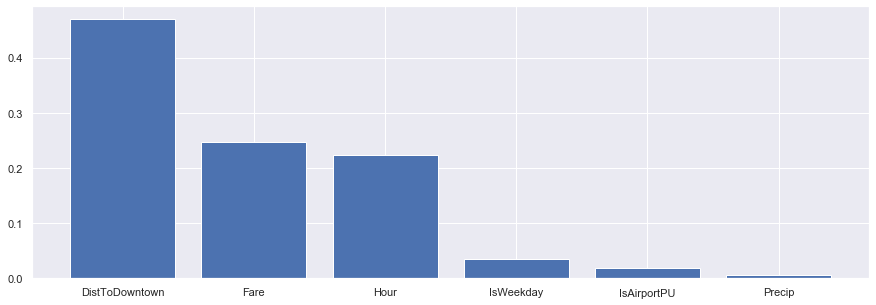

In [71]:
print(dict(zip(X.columns,rfrmod_0.feature_importances_)))
a,b=zip(*sorted(zip(X.columns,rfrmod_0.feature_importances_), key=lambda pair: pair[1],reverse=True)) 
plt.bar(a,b)

#### Result: 
By swapping fare for distance the R-squared for test data has improved to 0.79. Distance to downtown and average fare are the most important parameters.

<a id='enhance'></a>

## 4. Enhancing the Dataset
The EDA provided evidence that rideshare usage is focused on downtown, with a sharp dropoff in utilization as the pickup spot moves outwards from the city center.  The baseline model was built using distance from downtown as a spatial metric.  For this enhancement, a "Bearing" field was added to the data to indicate the direction of the pickup spot relative to downtown, in degrees relative to North (i.e. a pickup location due west of downtown has a bearing of 270).  In essence,the xy coordinates of the pickup locations have been converted to radial coordinates expressed as distance and angle relative to downtown Chicago.  The code used to perform this coordinate transformation is provided in my python module [RideshareDataPrep].(https://github.com/LisaATaylor/Rideshare/blob/master/RideshareDataPrep.py)

The EDA also suggested that Holidays have an effect on Rideshare usage.  An IsHoliday flag was added to the data to enable either filtering out these dates or incorporating them into the model.

In [22]:
#retreive updated dataset with added angle from downtown (bearing) field
hgdf=pd.read_pickle(os.path.join(datadir,'new_hourly_data_census_geo'))
hgdf=hgdf.loc[(hgdf.NumRides>0)&~hgdf.IsHoliday]#filter out holidays and records with zero rides (added for prior experiment not documented here)


In [23]:
#Try out of box randomm forest
rfrmod_b=RandomForestRegressor() 
Xb=hgdf[['DistToDowntown','bearing','Hour','DOW','IsAirport','MedIncome','PopDensity','MeanFare']]#'TripTotal',
yb=hgdf['NumRides']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.33)
rfrmod_b.fit(Xb_train,yb_train)
y_pred=rfrmod_b.predict(Xb_test)

In [24]:
#score results
rsq=rfrmod_b.score(Xb_test,yb_test)
rmse=np.sqrt(mean_squared_error(yb_test,y_pred))
print('R2:  {}   RMSE:  {} '.format(rsq,rmse))

R2:  0.8296427064073344   RMSE:  1.790187469930569 


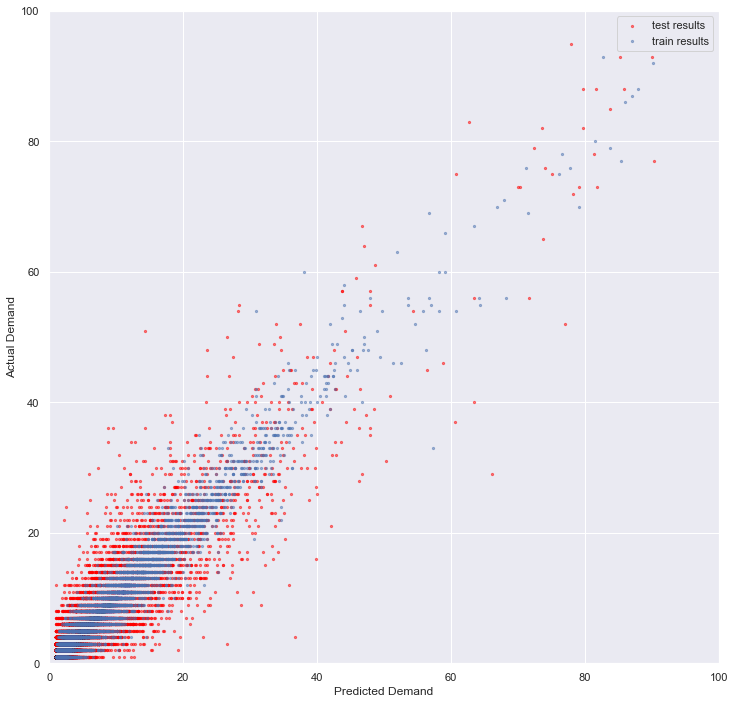

In [27]:
#plot results
fig,ax=plt.subplots(figsize=[12,12])
ax.scatter(y_pred[:50000],yb_test[:50000],color='red',label='test results',s=5,alpha=0.5)
y_train_pred=rfrmod_b.predict(Xb_train)
ax.scatter(y_train_pred[:50000],yb_train[:50000],label='train results',s=5,alpha=0.5)
ax.set_xlabel('Predicted Demand')
ax.set_ylabel('Actual Demand')
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.legend();

{'DistToDowntown': 0.366481617628737, 'bearing': 0.062081687666488194, 'Hour': 0.22199410594915076, 'DOW': 0.07852187569001064, 'IsAirport': 0.01676423070716161, 'MedIncome': 0.03225845699390213, 'PopDensity': 0.05664493566336979, 'MeanFare': 0.16525308970117997}


<BarContainer object of 8 artists>

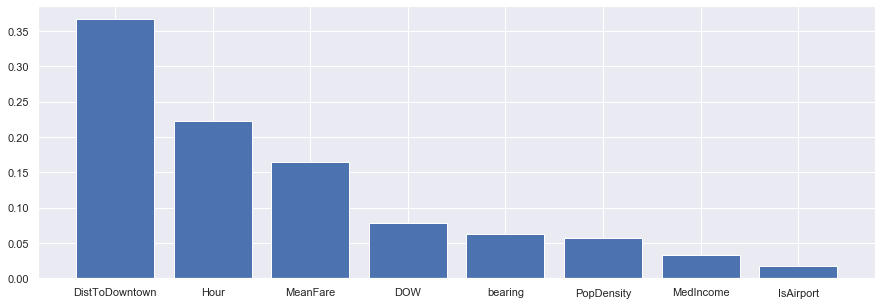

In [28]:
#Feature Importances
print(dict(zip(Xb.columns,rfrmod_b.feature_importances_)))
a,b=zip(*sorted(zip(Xb.columns,rfrmod_b.feature_importances_), key=lambda pair: pair[1],reverse=True)) 
plt.bar(a,b)

**Result:**  

By adding in the bearing, population density and income parameters, the r-squared has increased to 0.83.  Distance from downtown, date/time, and mean fare (per date, time, location) remain the most important predictors of utilization.

In [37]:
#Revisit bagging
bgmod_b=BaggingRegressor() 
Xb=hgdf[['DistToDowntown','bearing','Hour','DOW','IsAirport','MedIncome','PopDensity','MeanFare']]#'TripTotal',
#Xb['Precip']=Xb['Precip'].map({'Dry':0,'Wet':1})
yb=hgdf['NumRides']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.33)
bgmod_b.fit(Xb_train,yb_train)
y_pred=bgmod_b.predict(Xb_test)
rsq=bgmod_b.score(Xb_test,yb_test)
rmse=np.sqrt(mean_squared_error(yb_test,y_pred))
print('R2:  {}   RMSE:  {} '.format(rsq,rmse))

R2:  0.8301967236765683   RMSE:  1.8178371524956685 


**Result**

Again, bagging produces a similar result to random forest.

<a id='param'></a>

## 5.  Parameter Tuning

The Random Forest Regressor is trained by fitting a series of decision trees to bootstrap samples taken from the training dataset.  The out-of-bag (OOB) sample from each iteration is comprised of the portion of the dataset not included in the bootstrap sample, about 37% of the dataset.  The OOB score is the average r-squared calculated on the out-of-bag samples using the decision tree trained on the corresponding bootstrap samples.  By inspecting the OOB score with different parameter combinations, we can optimize the parameter settings for the model.


In [38]:
#Use OOB score to optimize number of estimators.  
n_est=[10,20,30,50]#10 is default
oobs=[]
for n in n_est:
    rfrmod_optn=RandomForestRegressor(n_estimators=n,oob_score=True,n_jobs=-1) 
    rfrmod_optn.fit(Xb,yb)
    oobs.append(rfrmod_optn.oob_score_)

In [40]:
oobs
# The r-squared continues to rise as more estimators are added.  
# Will generate final model with a high number of estimators, but continue developing with n_estimators=10 for better performance.

[0.7968116116099633,
 0.8258392251982651,
 0.8311299021077991,
 0.8351069852893312]

In [45]:
#use oob scores to optimize other parameters: selection of max_features, split criterion

#Max depth was run over several iterations to optimize the range of values (to identify best value):
#  first round 5,10,20,30 --> best = 20
#  second round 15,20,25 --> best = 15
#  third round 12,114,16,18 --> best = 16 (winner)

max_features=['sqrt','log2',None]#None equivalent to bagging
#max_depth=[5,10,20,30]#best score at 20 
#max_depth=[15,20,25]#best score at 15
max_depth=[12,14,16,18]
for f in max_features:
    for d in max_depth:
        mod=RandomForestRegressor(n_estimators=10,max_features=f,max_depth=d,oob_score=True,n_jobs=-1)
        mod.fit(Xb,yb)
        print('Feature Selection: {}    Max Depth: {}   OOB Score: {}'.format(f,d,mod.oob_score_))

# We see the best results with tree max depth=16 and allowing all parameters to be used for a branch (i.e. bagging).  
# Tree depth appears to be more important than the feature selection method.     

Feature Selection: sqrt    Max Depth: 12   OOB Score: 0.7739268550390843
Feature Selection: sqrt    Max Depth: 14   OOB Score: 0.8014030432379788
Feature Selection: sqrt    Max Depth: 16   OOB Score: 0.8066656438345442
Feature Selection: sqrt    Max Depth: 18   OOB Score: 0.806497458466342
Feature Selection: log2    Max Depth: 12   OOB Score: 0.7876965880659843
Feature Selection: log2    Max Depth: 14   OOB Score: 0.8038840088300503
Feature Selection: log2    Max Depth: 16   OOB Score: 0.8141392981920935
Feature Selection: log2    Max Depth: 18   OOB Score: 0.8130652617546602
Feature Selection: None    Max Depth: 12   OOB Score: 0.8053608240114605
Feature Selection: None    Max Depth: 14   OOB Score: 0.8193361031189319
Feature Selection: None    Max Depth: 16   OOB Score: 0.8227250346555957
Feature Selection: None    Max Depth: 18   OOB Score: 0.8179809561430385


In [49]:
#lets try best combination of max_depth, max_features and n_estimators
rfrmod_final=RandomForestRegressor(n_estimators=50,max_depth=18, max_features=None)
rfrmod_final.fit(Xb_train,yb_train)
y_pred=rfrmod_final.predict(Xb_test)
rsq=rfrmod_final.score(Xb_test,yb_test)
rmse=np.sqrt(mean_squared_error(yb_test,y_pred))
print('R2:  {}   RMSE:  {} '.format(rsq,rmse))

R2:  0.8494422484601137   RMSE:  1.7117230642349872 


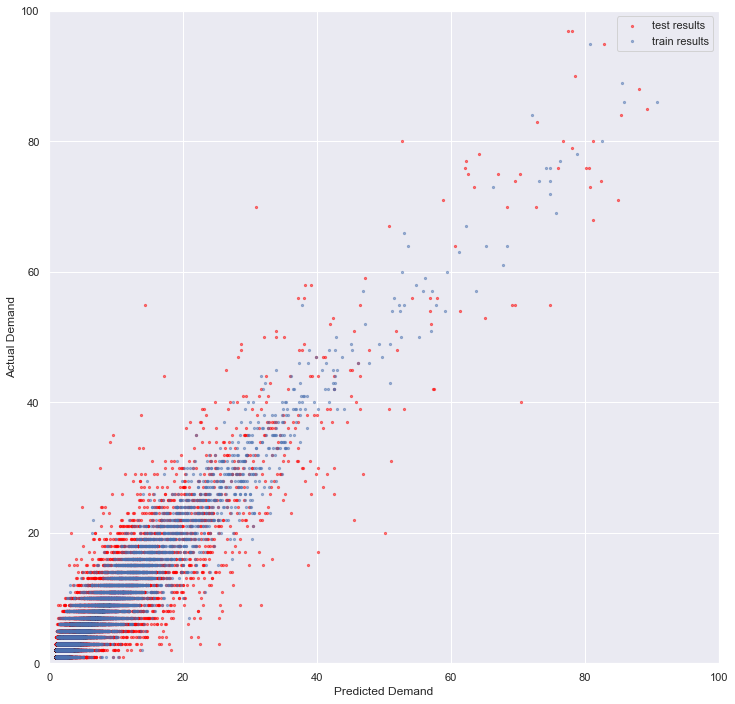

In [58]:
fig,ax=plt.subplots(figsize=[12,12])
ax.scatter(y_pred[:50000],yb_test[:50000],color='red',label='test results',s=5,alpha=0.5)
y_train_pred=rfrmod_final.predict(Xb_train)
ax.scatter(y_train_pred[:50000],yb_train[:50000],label='train results',s=5,alpha=0.5)
ax.set_xlabel('Predicted Demand')
ax.set_ylabel('Actual Demand')
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.legend();

**Results**

After calibration, the R-squared has increased from 0.83 to 0.85.

<a id='final'></a>

## 6.  Final Results
An Ipywidgets dashboard was created to illustrate the model output.  By selecting a few parameters, a snapshot of predicted rideshare usage can be generated for a typical week.

In [70]:
import ipywidgets as widgets
dist_range_slider = widgets.FloatLogSlider(value=1,min=-2,max=2,    step=0.2,    description='Distance: ',
    orientation='horizontal',layout={'width': '500px'})
bear_selector=widgets.Dropdown(options=[('N',0),('NE',45),('E',90),('SE',135),('S',180),('SW',225),('W',270),('NW',315)],
                               value=270,layout={'width':'200px'},description='Direction:')
#bear_slider = widgets.IntSlider(value=180,min=0,max=360,    step=15,    description='Bearing: ',
#   orientation='horizontal',layout={'width': '500px'})
income_slider = widgets.IntSlider(value=50000,min=20000,max=300000,    step=20000,    description='Income: ',
    orientation='horizontal',layout={'width': '500px'})
density_slider = widgets.IntSlider(value=8000,min=2000,max=12000,    step=1000,    description='Density: ',
    orientation='horizontal',layout={'width': '500px'})
fare_slider = widgets.IntSlider(value=10,min=1,max=100,    step=1,    description='Mean Fare: ',
    orientation='horizontal',layout={'width': '500px'})
#precip_checkbox=widgets.Checkbox(value=False,description='Precipitation')
airport_checkbox=widgets.Checkbox(value=False,description='Airport')

def predict_usage(distance=1,bearing=180,income=50000,density=8000,fare=10,isairport=0):#(tract):##,precip=0,isairport=0):#month,temperature,isholiday,side,model):
    model=rfrmod_final
    data=dict()

    
    data['distance']=distance
    #data['precip']=precip
    data['isairport']=isairport
    data['bearing']=bearing
    data['density']=isairport
    data['income']=income
    data['fare']=fare

    to_predict=pd.Series(data).to_frame(1).transpose()#one record
    to_predict_df=pd.concat([to_predict]*168)#copy for each day of week and hour of day combination
    to_predict_df['Hour']=list(range(24))*7
    to_predict_df['DOW']=list(range(7))*24

    to_predict_df=to_predict_df[['distance','bearing','Hour','DOW','isairport','income','density','fare']]#reorder columns
    to_predict_df['result']=model.predict(to_predict_df)

    heatdf=pd.pivot_table(data=to_predict_df,index='DOW',columns='Hour',values='result',aggfunc='sum')
    heatdf.index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    heatdf=heatdf.fillna(0)
    fig,axes=plt.subplots(1,1,figsize=(15,4))
    sns.heatmap(heatdf,ax=axes,vmin=0,vmax=20)

widgets.interact(
    predict_usage,
    #tract=tractselector
    distance=dist_range_slider,
    bearing=bear_selector,
    #precip=precip_checkbox,
    density=density_slider,
    income=income_slider,
    fare=fare_slider,
    isairport=airport_checkbox
);

interactive(children=(FloatLogSlider(value=1.0, description='Distance: ', layout=Layout(width='500px'), max=2.…

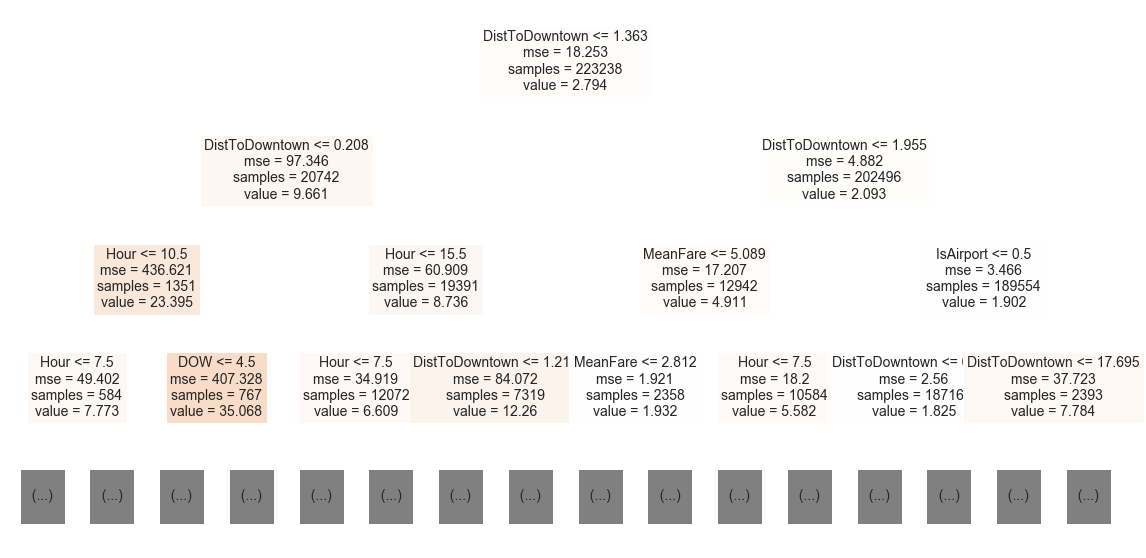

In [62]:
#inspect example from final ensemble of trees
mod=rfrmod_final.estimators_[0]
fig,ax=plt.subplots(figsize=(20,10))
plot_tree(mod, max_depth=3,feature_names=Xb_train.columns, filled=True,fontsize=14);
